# Cutoffs for spatial feature normalization

## Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import math
import multiprocessing
from pathlib import Path
import pickle
import sys

import matplotlib.pyplot as plt
import pandas as pd

sys.path.append('../..')
from kinsim_structure.auxiliary import KlifsMoleculeLoader, PdbChainLoader
from kinsim_structure.encoding import SpatialFeatures, Fingerprint

_ColormakerRegistry()

## IO paths

In [4]:
path_to_data = Path('/') / 'home' / 'dominique' / 'Documents' / 'data' / 'kinsim' / '20190724_full'
path_to_kinsim = Path('/') / 'home' / 'dominique' / 'Documents' / 'Projects' / 'kinsim_structure'
path_to_results = path_to_kinsim / 'examples' / 'results' / 'postprocessing'

metadata_path = path_to_data / 'preprocessed' / 'klifs_metadata_preprocessed.csv'

## Load metadata

In [5]:
klifs_metadata = pd.read_csv(metadata_path)

In [6]:
klifs_metadata.head()

,Unnamed: 0,Unnamed: 0.1,metadata_index,kinase,family,groups,pdb_id,chain,alternate_model,species,...,ac_helix,rmsd1,rmsd2,qualityscore,pocket,resolution,missing_residues,missing_atoms,full_ifp,code
0,0,0,2886,AAK1,NAK,Other,4wsq,B,A,Human,...,in,0.777,2.125,8.6,EVLAEGGFAIVFLCALKRMVCKREIQIMRDLSKNIVGYIDSLILMD...,1.95,0,14,0000000000000010000001000000000000000000000000...,HUMAN/AAK1/4wsq_chainB_altA
1,1,1,10043,AAK1,NAK,Other,5l4q,A,A,Human,...,in,0.780,2.137,9.7,EVLAEGGFAIVFLCALKRMVCKREIQIMRDLSKNIVGYIDSLILMD...,1.97,0,3,0000000000000010000000000000000000000000000000...,HUMAN/AAK1/5l4q_chainA_altA
2,2,2,7046,AAK1,NAK,Other,5te0,A,-,Human,...,in,0.776,2.120,8.8,EVLAEGGFAIVFLCALKRMVCKREIQIMRDLSKNIVGYIDSLILMD...,1.90,0,12,1000101000000010000001000000000000000000000000...,HUMAN/AAK1/5te0_chainA
3,3,3,843,ABL1,Abl,TK,2f4j,A,-,Human,...,in,0.779,2.128,8.0,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,1.91,0,0,0000000000000010000001000000000000000000000000...,HUMAN/ABL1/2f4j_chainA
4,4,4,815,ABL1,Abl,TK,2g1t,A,-,Human,...,out,0.825,2.154,8.0,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,1.80,0,0,NaN,HUMAN/ABL1/2g1t_chainA


In [7]:
klifs_metadata.shape

(3880, 25)

## Distance features

### Generate/load distance features

In [8]:
with open(path_to_results / 'distances_all.p', 'rb') as f:
    all_distances = pickle.load(f)

In [9]:
all_distances.shape

(325293, 11)

In [10]:
all_distances.reset_index(inplace=True)

In [11]:
all_distances.head()

,klifs_id,distance_to_centroid,distance_to_hinge_region,distance_to_dfg_region,distance_to_front_pocket,metadata_index,kinase,pdb_id,chain,alternate_model,qualityscore,resolution
0,1,17.19,12.8,19.08,14.13,2886,AAK1,4wsq,B,A,8.6,1.95
1,2,15.09,11.64,16.48,11.69,2886,AAK1,4wsq,B,A,8.6,1.95
2,3,12.41,9.24,15.13,8.24,2886,AAK1,4wsq,B,A,8.6,1.95
3,4,11.80,10.34,13.67,7.22,2886,AAK1,4wsq,B,A,8.6,1.95
4,5,12.80,12.41,12.79,9.24,2886,AAK1,4wsq,B,A,8.6,1.95


In [12]:
all_distances.dtypes

klifs_id                      int64
distance_to_centroid        float64
distance_to_hinge_region     object
distance_to_dfg_region       object
distance_to_front_pocket     object
metadata_index                int64
kinase                       object
pdb_id                       object
chain                        object
alternate_model              object
qualityscore                float64
resolution                  float64
dtype: object

In [13]:
all_distances.distance_to_hinge_region = all_distances.distance_to_hinge_region.astype(dtype=float)
all_distances.distance_to_dfg_region = all_distances.distance_to_dfg_region.astype(dtype=float)
all_distances.distance_to_front_pocket = all_distances.distance_to_front_pocket.astype(dtype=float)

In [14]:
all_distances.dtypes

klifs_id                      int64
distance_to_centroid        float64
distance_to_hinge_region    float64
distance_to_dfg_region      float64
distance_to_front_pocket    float64
metadata_index                int64
kinase                       object
pdb_id                       object
chain                        object
alternate_model              object
qualityscore                float64
resolution                  float64
dtype: object

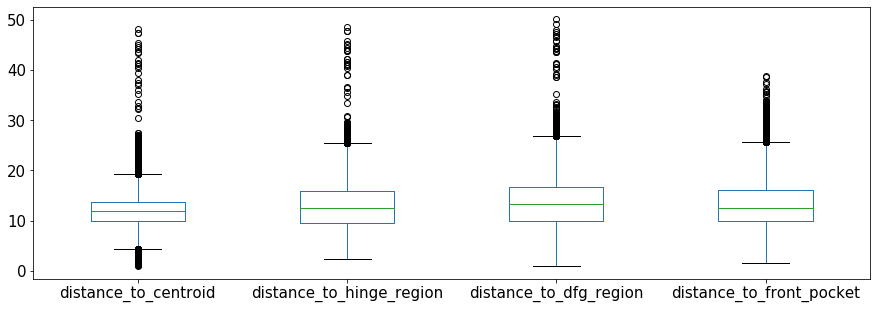

In [15]:
boxplot = all_distances[
    [
        'distance_to_centroid', 
        'distance_to_hinge_region', 
        'distance_to_dfg_region', 
        'distance_to_front_pocket'
    ]
].plot(
    kind='box',
    figsize=(15,5), 
    fontsize=15
)

In [16]:
boxplot.get_figure().savefig(path_to_results / 'distribution_distances.png', dpi=300)

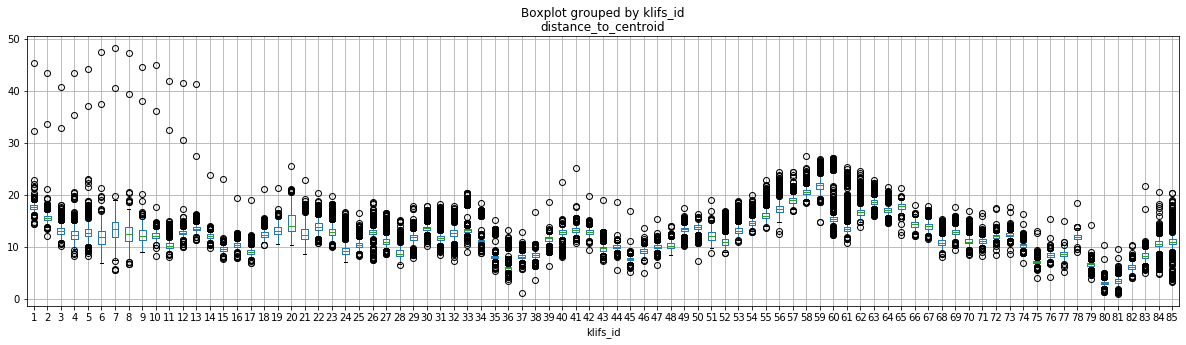

In [17]:
b1 = all_distances.boxplot(
    column='distance_to_centroid', 
    by='klifs_id',
    figsize=(20,5), 
    fontsize=10
)

In [18]:
all_distances[all_distances['distance_to_centroid'] > 30]['metadata_index'].unique()

array([  11, 6942])

In [19]:
all_distances[all_distances['distance_to_centroid'] > 30]['pdb_id'].unique()

array(['4qd6', '5j0a'], dtype=object)

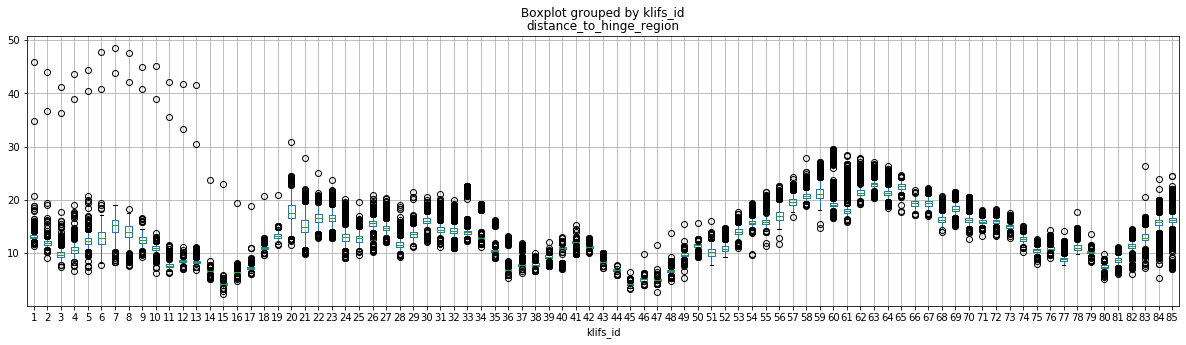

In [20]:
b2 = all_distances.boxplot(
    column='distance_to_hinge_region', 
    by='klifs_id',
    figsize=(20,5), 
    fontsize=10
)

In [21]:
all_distances[all_distances['distance_to_hinge_region'] > 31]['metadata_index'].unique()

array([  11, 6942])

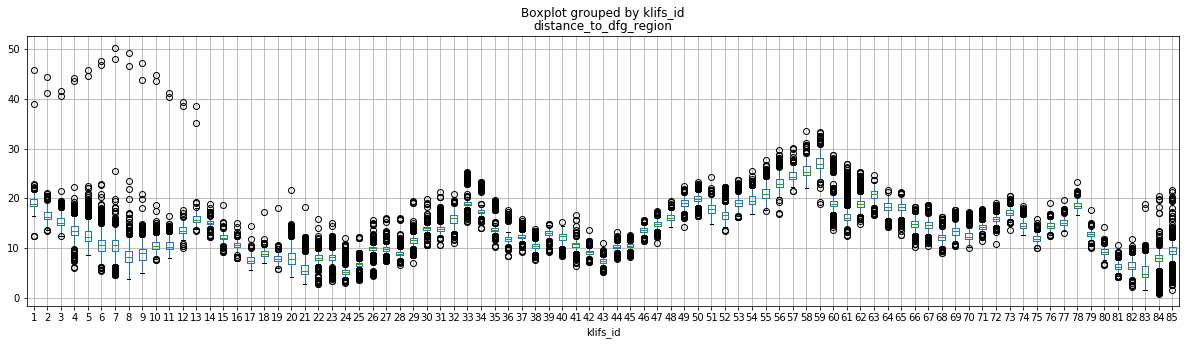

In [22]:
b3 = all_distances.boxplot(
    column='distance_to_dfg_region', 
    by='klifs_id',
    figsize=(20,5), 
    fontsize=10
)

In [23]:
all_distances[all_distances['distance_to_dfg_region'] > 35]['metadata_index'].unique()

array([  11, 6942])

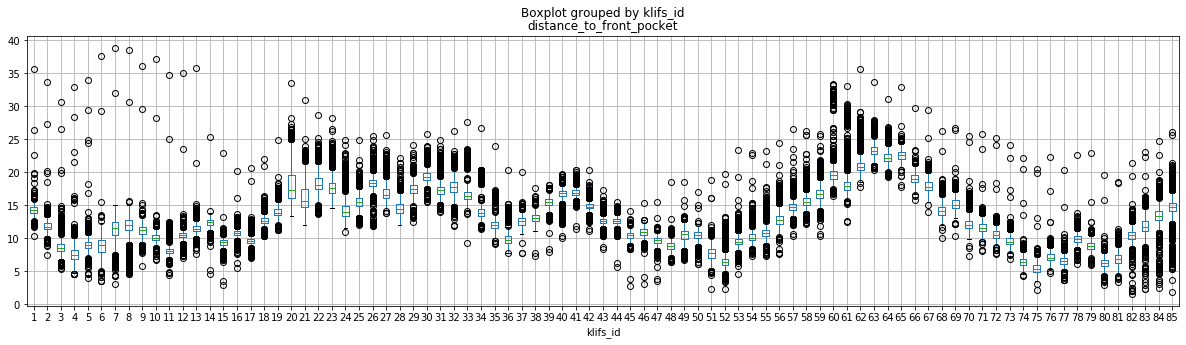

In [24]:
b2 = all_distances.boxplot(
    column='distance_to_front_pocket', 
    by='klifs_id',
    figsize=(20,5), 
    fontsize=10
)

In [25]:
all_distances[all_distances['distance_to_front_pocket'] > 35]['metadata_index'].unique()

array([6942])

### Distance percentiles

In [26]:
percentiles = [.01, 0.05, .1, .25, .5, .75, .9, .95, .99]

In [27]:
all_distances.iloc[:, 1:5].describe(percentiles=percentiles)

,distance_to_centroid,distance_to_hinge_region,distance_to_dfg_region,distance_to_front_pocket
count,325293.000000,325179.00000,324561.000000,314788.000000
mean,11.990455,12.87617,13.548047,13.059487
std,3.506031,4.57499,4.865739,4.291416
min,0.950000,2.37000,0.900000,1.640000
1%,3.050000,4.10000,4.620000,5.460000
5%,6.480000,6.09000,6.400000,6.590000
10%,7.880000,6.95000,7.510000,7.790000
25%,9.910000,9.59000,9.910000,9.880000
50%,12.000000,12.56000,13.270000,12.490000
75%,13.640000,15.96000,16.710000,16.160000


## Moment features

### Generate/load moment features

In [28]:
groups = all_distances.groupby(['pdb_id', 'chain', 'alternate_model'])

all_moments = {}

for group_name, group in groups:
    distances = group.iloc[:, 1:5]
    distances.index = group.iloc[:, 0]
    fingerprint = Fingerprint()
    moments = fingerprint._calc_moments(distances)
    
    all_moments[group_name] = moments

In [29]:
len(all_moments)

3880

In [30]:
all_moments_df = pd.concat(all_moments)

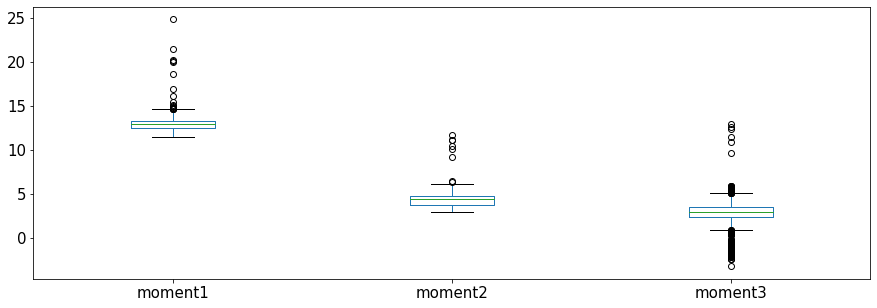

In [31]:
boxplot = all_moments_df.plot(
    kind='box',
    figsize=(15,5), 
    fontsize=15
)

In [32]:
boxplot.get_figure().savefig(path_to_results / 'distribution_moments.png', dpi=300)

### Moment percentiles

In [33]:
all_moments_df.describe(percentiles=percentiles)

,moment1,moment2,moment3
count,15375.000000,15375.000000,15375.000000
mean,12.866906,4.291473,2.833801
std,0.641459,0.565807,1.025317
min,11.466393,2.934483,-3.283178
1%,11.681130,3.288599,-1.468455
5%,11.841136,3.373257,1.390540
10%,11.925153,3.439746,1.784174
25%,12.421807,3.757153,2.391681
50%,12.916941,4.441735,2.908560
75%,13.303529,4.705685,3.443275
